In [1]:
# imports
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb
import copy
import os, sys, pathlib
import yaml
import json
import requests

from deq2ff.plotting.style import (
    set_seaborn_style,
    PALETTE,
    entity,
    projectmd,
    projectoc,
    plotfolder,
    human_labels,
    set_style_after,
    myrc,
    cdict,
    reset_plot_styles,
)
from deq2ff.plotting.dashboard import (
    get_runs_from_wandb,
    filter_best_runs,
    mark_sota,
    add_best_run,
    preprocess_df,
    print_table_acc_time,
    plot_acc_vs_speed,
    plot_acc_vs_speed_errorbar,
    norm_targets,
    print_table_acc,
)


nans = ["NaN", pd.NA, None, float("inf"), np.nan]

# OC20

In [2]:
# Config
project = projectoc

if project == projectmd:
    error_metric = "summary.test_f_mae"
    energy_metric = "summary.test_e_mae"
elif project == projectoc:
    # summary.train/forces_mae, val,
    error_metric = "summary.val/forces_mae"
    energy_metric = "summary.val/energy_mae"

In [3]:
if project == projectoc:
    tag = "depthoc"
    fname = "depthocv1"
else:
    tag = "depthmd"
    fname = "depthmdv1"

dfdepth = get_runs_from_wandb(
    project=project,
    download_data=True,
    filters={
        "tags": tag,
        # "$and": [{"tags": "md17"}, {"tags": "eval"}],
        # "state": "finished",
        # "$or": [{"tags": "md17"}, {"tags": "main2"}, {"tags": "inference"}],
        "state": "finished",
        # "$or": [{"state": "finished"}, {"state": "crashed"}],
    },
    fname="depth" + fname,
)
print(f"Found {len(dfdepth)} of 8+2 runs")

dfdepth = preprocess_df(df=dfdepth, project=project, error_metric=error_metric)

Found 16 runs:
Saved dataframe.
Found 16 of 8+2 runs
before filter: 16
after filter: 16
replacing 10/16 0's with 200k
Adding optim.max_epochs to target


In [4]:
dfdepth = mark_sota(dfdepth, error_metric=error_metric)


Models: ['E4' 'DEQ1' 'E6' 'E1' 'E2' 'E3' 'E7' 'E5' 'E8' 'DEQ2' 'E9' 'E10' 'E11'
 'E12' 'E13' 'E14']


In [5]:

table = print_table_acc(
    df=dfdepth, # df_best_runs, df_alt
    dnames=["oc20"],
    models=["E1", "E4", "E8", "DEQ1", "DEQ2"],
    error_metric=error_metric,
    corner="OC20 200k",
)

\begin{tabular}{lc}
\toprule[1.2pt]
OC20 200k & Force \\
\midrule[1.2pt]
\equiformer{} (1 layer) & $0.052$ \\
\equiformer{} (4 layers) & $0.045$ \\
\equiformer{} (8 layers) & $0.045$ \\
\midrule[0.6pt]
DEQ (1 layer) & $\mathbf{0.043}$ \\
DEQ (2 layers) & $\mathbf{0.042}$ \\


Saved plot to 
 /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/acc_vs_depth_oc.png


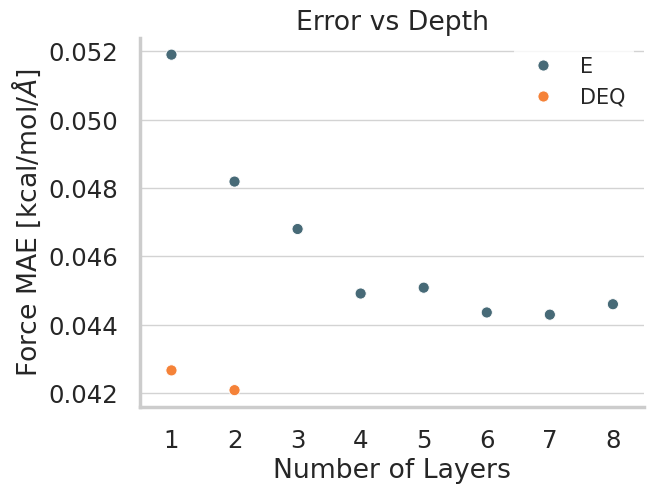

In [13]:
# plot acc over depth

y = error_metric
x = "config.model.num_layers"
hue = "Class"
data = dfdepth.copy()

# plot
reset_plot_styles()
set_seaborn_style(palette="deep")

fig, ax = plt.subplots()
sns.scatterplot(
    x=x,
    y=y,
    hue=hue,
    data=data,
    ax=ax,
    palette=cdict
)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))
# vertical xtick labels
# plt.xticks(rotation=90)
plt.title("Error vs Depth")

# set xticks 1, 2, 3, 4, 5, 6, 7, 8
plt.xticks(np.arange(1, 9, 1))

plt.xlim(0.5, 8.5)

# horizontal grid
plt.grid(axis="y")

set_style_after(ax=ax)

# save
fname = "acc_vs_depth_oc"
plt.savefig(f"{plotfolder}/{fname}.png")
print(f"Saved plot to \n {plotfolder}/{fname}.png")
plt.show()

In [7]:
# [c for c in dfdepth.keys() if ("summary" in c) and ("gradients" not in c)]

Saved plot to 
 /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/acc_vs_params_oc.png


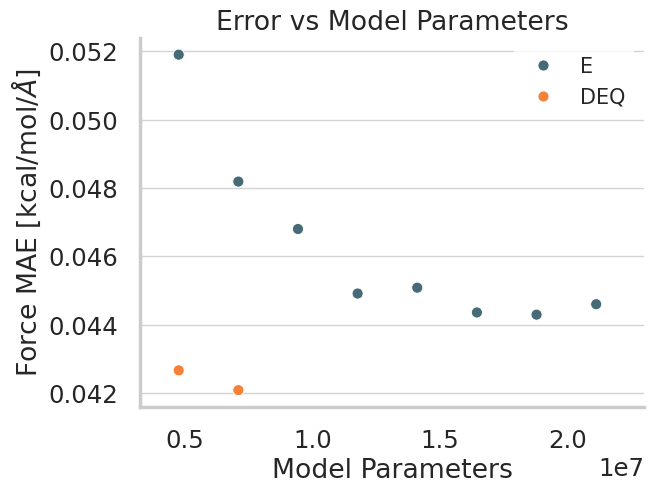

In [10]:
# Accuracy over model parameters
#  “summary.ModelParameters”

y = error_metric
# x = "config.model.num_layers"
x = "summary.ModelParameters"
hue = "Class"
data = dfdepth.copy()

# data["Class"] = data["Class"].apply(lambda x: "E1-8" if x in ["E1", "E4", "E8"] else x)

# plot
reset_plot_styles()
set_seaborn_style(palette="deep")

fig, ax = plt.subplots()
sns.scatterplot(
    x=x,
    y=y,
    hue=hue,
    data=data,
    ax=ax,
    palette=cdict
)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))
# vertical xtick labels
# plt.xticks(rotation=90)
plt.title("Error vs Model Parameters")

# horizontal grid
plt.grid(axis="y")

plt.xlim(right=2.3e7)


set_style_after(ax=ax)

# save
fname = "acc_vs_params_oc"
plt.savefig(f"{plotfolder}/{fname}.png")
print(f"Saved plot to \n {plotfolder}/{fname}.png")
plt.show()

Saved plot to 
 /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/acc_vs_params_oc.png


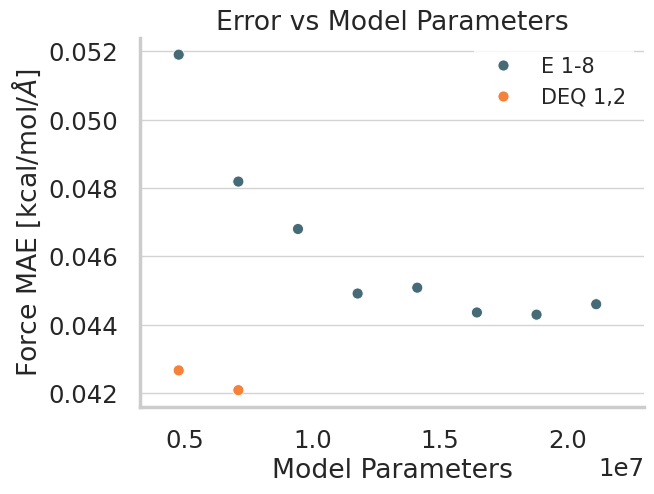

In [9]:
# Accuracy over model parameters
#  “summary.ModelParameters”

y = error_metric
# x = "config.model.num_layers"
x = "summary.ModelParameters"
data = dfdepth.copy()

hue = "Model"
data["Model"] = data["Model"].apply(lambda x: "E 1-8" if "DEQ" not in x else x)
data["Model"] = data["Model"].apply(lambda x: "DEQ 1,2" if "DEQ" in x else x)

# plot
reset_plot_styles()
set_seaborn_style(palette="deep")

fig, ax = plt.subplots()
sns.scatterplot(
    x=x,
    y=y,
    hue=hue,
    data=data,
    ax=ax,
    palette=cdict
)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))
# vertical xtick labels
# plt.xticks(rotation=90)
plt.title("Error vs Model Parameters")

# horizontal grid
plt.grid(axis="y")

plt.xlim(right=2.3e7)


set_style_after(ax=ax)

# save
fname = "acc_vs_params_oc"
plt.savefig(f"{plotfolder}/{fname}.png")
print(f"Saved plot to \n {plotfolder}/{fname}.png")
plt.show()